In [2]:
a = R.from_quat(demo_waypoints[0][3:]).as_euler("xyz")
a

array([-3.12649077, -0.10964465, -0.02777028])

In [1]:
from scipy.spatial.transform import Rotation as R
import json
import numpy as np

def create_homogeneous_matrix(xyz, quaternion):
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4) 
    T[:3, :3] = rotation_matrix
    T[:3, 3] = xyz 

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T


K = np.load("handeye/intrinsics_d415.npy")
T_WC = np.load("handeye/T_WC_head.npy")
DIR = "pencile_sharpener"

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

array([[ 5.04181257e-01,  9.18543602e-02,  4.81437095e-01,
        -9.98378663e-01,  1.34497292e-02, -5.48927079e-02,
         6.77801139e-03],
       [ 4.40391932e-01,  1.40902490e-01,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04],
       [ 4.36594966e-01, -8.75230986e-02,  2.84233720e-01,
        -9.83311430e-01, -1.57137508e-02,  7.59195973e-03,
         1.81091334e-01],
       [ 4.40391932e-01,  1.10902490e-01,  2.97994343e-01,
         9.97853233e-01, -1.53176029e-02, -6.36702943e-02,
         6.25089375e-04]])

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def compute_pre_grasp_pose(grasp_pos, grasp_quat, approach_distance):
    # Convert quaternion to rotation matrix
    rotation = R.from_quat(grasp_quat).as_matrix()

    # Approach vector is the negative Z-axis of the end-effector in world frame
    approach_vector = -rotation[:, 2]

    # Compute the pre-grasp position
    pre_grasp_pos = grasp_pos + approach_vector * approach_distance

    # Pre-grasp orientation is the same as grasp orientation
    pre_grasp_quat = grasp_quat

    return pre_grasp_pos, pre_grasp_quat

# Given grasp pose
grasp_pos = np.array([      0.3942699968903538,
      0.10932386737208159,
      0.3461344794241349])
grasp_quat = np.array([      0.9878462476621214,
      0.0020249385540891856,
      0.041857843620528766,
      0.14967836026346082])

# Approach distance (example value)
approach_distance = 0.1

# Compute pre-grasp pose
pre_grasp_pos, pre_grasp_quat = compute_pre_grasp_pose(grasp_pos, grasp_quat, approach_distance)

# Print results
print("Pre-Grasp Position:", pre_grasp_pos)
print("Pre-Grasp Quaternion:", pre_grasp_quat)


Pre-Grasp Position: [0.38593956 0.13887876 0.44130334]
Pre-Grasp Quaternion: [0.98784625 0.00202494 0.04185784 0.14967836]


In [13]:
np.concatenate([pre_grasp_pos, pre_grasp_quat])

array([0.38593956, 0.13887876, 0.44130334, 0.98784625, 0.00202494,
       0.04185784, 0.14967836])

In [8]:
from trajectory_utils import translation_from_matrix, quaternion_from_matrix, pose_inv, \
                             project3D, create_homogeneous_matrix, apply_transformation_to_waypoints
import numpy as np

T_delta_world = np.eye(4)
live_waypoints = apply_transformation_to_waypoints(demo_waypoints[:2], T_delta_world, project3D=True)
live_waypoints

[[0.5041812568964179,
  0.09185436015924689,
  0.48143709451847916,
  0.9983786626178941,
  -0.013449729176136647,
  0.05489270785818523,
  -0.00677801138900335],
 [0.492955653926487,
  -0.15312450854488374,
  0.3452616703174216,
  0.984508539121783,
  0.06697911109044077,
  -0.0013241054126860263,
  -0.16203389095705556]]

In [3]:
K1 = np.load("handeye/intrinsics_d415.npy")
K2 = np.load("handeye/intrinsics_d405.npy")

print(K1)
print(K2)

[[909.92120361   0.         646.23828125]
 [  0.         908.72631836 355.08041382]
 [  0.           0.           1.        ]]
[[431.56503296   0.         418.71490479]
 [  0.         431.18637085 235.15617371]
 [  0.           0.           1.        ]]


In [4]:
point_2Ds = []

for i in range(len(demo_waypoints)):
    point3d = pose_inv(T_WC)  @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

point_2Ds

[array([859.99596727, 289.76787131]),
 array([861.75347694, 431.36929211]),
 array([639.83852484, 443.16998691]),
 array([824.9123082, 431.0055063])]

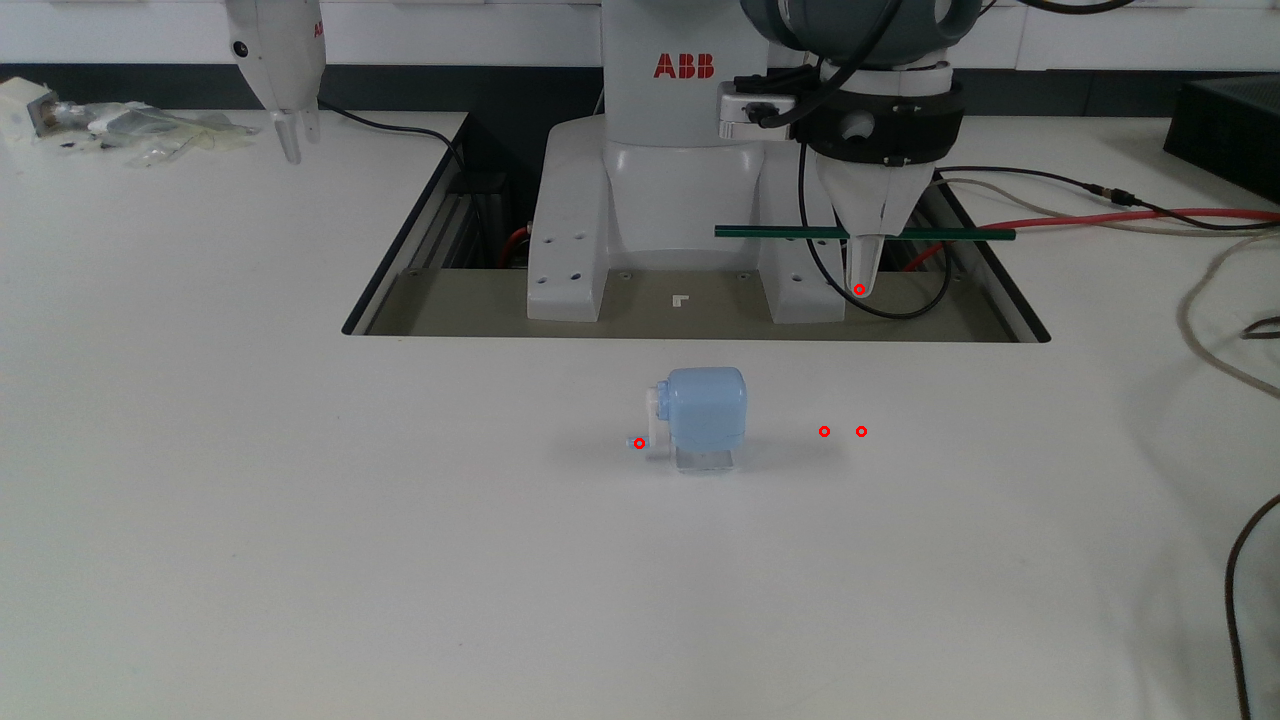

In [5]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

In [193]:
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])

pose_inv(T_GRIP_EEF)

array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   , -0.136],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [7]:

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

K_wrist = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.128], [0, 0, 0, 1])
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
# T_EEF_World[2, 3] -= 0.06
for i in range(len(demo_waypoints)):

    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K_wrist, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()

[array([458.6021028 , 599.15127336]), array([617.71682997, 454.87977658]), array([592.01106102, 157.74531573]), array([616.64272391, 404.24191853])]


In [196]:
create_homogeneous_matrix([0.58381608, -0.00932566, 0.3015399], [0, 0, 0, 1])


array([[ 1.        ,  0.        ,  0.        ,  0.58381608],
       [ 0.        ,  1.        ,  0.        , -0.00932566],
       [ 0.        ,  0.        ,  1.        ,  0.3015399 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

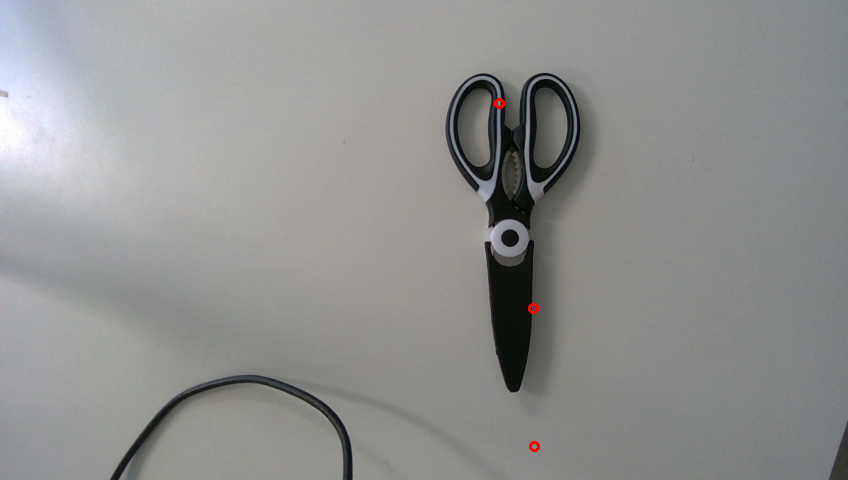

In [189]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_d405_rgb.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

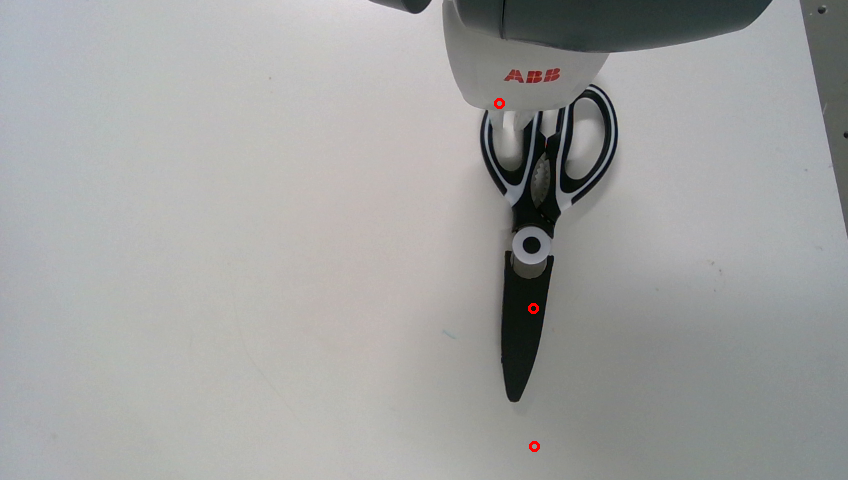

In [172]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_right_in_view.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

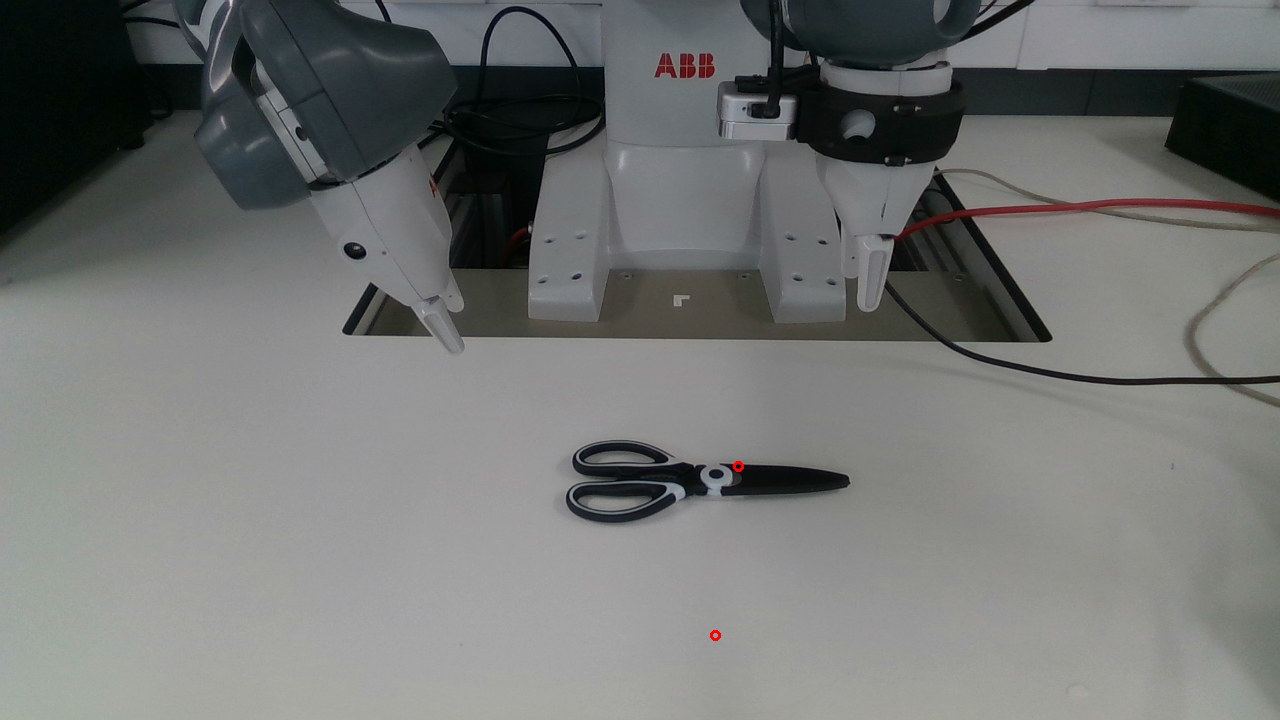

In [36]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in [[738, 466], [715, 635], [800, 910]]:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb